In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline

In [12]:
price_df = pd.read_csv('../data/ml_features.csv', parse_dates=['date'])
price_df.set_index('date', inplace=True)
actual = price_df['spike_30']
price_df = price_df['price_error'] * -1 # SHORT RTDA

In [13]:
transformer_df = pd.read_csv('../data/testing_results/transformerv2_predictions.csv')
transformer_df.drop(columns=['Unnamed: 0'], errors='ignore', inplace=True)

# Determine the number of rows so we can generate the corresponding timestamps.
n_rows = transformer_df.shape[0]
# Generate hourly timestamps ending on "2023-12-31 23:00:00"
timestamps = pd.date_range(end=price_df.index[-1], periods=n_rows, freq='h')
transformer_df.insert(0, 'timestamp', timestamps)
transformer_df.set_index('timestamp', inplace=True)
# Rename the spike prediction column to 'predicted_spike_transformer'
if 'predicted_spike_transformer' not in transformer_df.columns:
    col_to_rename = transformer_df.columns[0]  # assuming only column with predictions
    transformer_df.rename(columns={col_to_rename: 'predicted_spike_transformer'}, inplace=True)
print(price_df.info())
transformer_df.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 52093 entries, 2018-01-01 01:00:00 to 2023-12-31 23:00:00
Series name: price_error
Non-Null Count  Dtype  
--------------  -----  
52093 non-null  float64
dtypes: float64(1)
memory usage: 814.0 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10409 entries, 2022-10-24 07:00:00 to 2023-12-31 23:00:00
Data columns (total 1 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   predicted_spike_transformer  10409 non-null  float64
dtypes: float64(1)
memory usage: 162.6 KB


In [14]:
start_date = '2022-10-27'
end_date = '2023-12-31'
transformer_df = transformer_df.loc[start_date:end_date]
price_df = price_df.loc[start_date:end_date]
print(transformer_df.shape)
print(price_df.shape)

(10344, 1)
(10292,)


In [15]:
missing_in_price = transformer_df.index.difference(price_df.index)
print("Missing timestamps in price_df:\n", missing_in_price)

Missing timestamps in price_df:
 DatetimeIndex(['2023-03-12 02:00:00', '2023-03-12 03:00:00',
               '2023-03-12 04:00:00', '2023-03-12 05:00:00',
               '2023-03-12 06:00:00', '2023-03-12 07:00:00',
               '2023-03-12 08:00:00', '2023-03-12 09:00:00',
               '2023-03-12 10:00:00', '2023-03-12 11:00:00',
               '2023-03-12 12:00:00', '2023-03-12 13:00:00',
               '2023-03-12 14:00:00', '2023-03-12 15:00:00',
               '2023-03-12 16:00:00', '2023-03-12 17:00:00',
               '2023-03-12 18:00:00', '2023-03-12 19:00:00',
               '2023-03-12 20:00:00', '2023-03-12 21:00:00',
               '2023-03-12 22:00:00', '2023-03-12 23:00:00',
               '2023-03-13 00:00:00', '2023-03-13 01:00:00',
               '2023-03-13 02:00:00', '2023-03-13 03:00:00',
               '2023-03-13 04:00:00', '2023-03-13 05:00:00',
               '2023-03-13 06:00:00', '2023-03-13 07:00:00',
               '2023-03-13 08:00:00', '2023-03-13 09

In [16]:
common_index = transformer_df.index.intersection(price_df.index)
transformer_df = transformer_df.loc[common_index]
price_df = price_df.loc[common_index]

print(transformer_df.shape)
print(price_df.shape)

(10292, 1)
(10292,)


In [17]:
df = transformer_df.join(price_df, how='inner')
    
mask = (actual.loc[start_date:end_date] == 1) & (df['price_error'] > 30)
has_spikes_above_30 = mask.any()  # True/False
count_spikes_above_30 = mask.sum()  # how many rows
print(df['predicted_spike_transformer'].sum())
print(count_spikes_above_30)
df.head()

2120.0
0


,predicted_spike_transformer,price_error
2022-10-27 00:00:00,0.0,2.705000
2022-10-27 01:00:00,1.0,2.265833
2022-10-27 02:00:00,1.0,4.905833
2022-10-27 03:00:00,1.0,3.963333
2022-10-27 04:00:00,1.0,1.359167


In [18]:
initial_capital = 100.0
long_short= df.loc[df['predicted_spike_transformer'] == 1, 'price_error'] * -1 # nothing predictions
df.loc[df['predicted_spike_transformer'] == 1, 'price_error'] = long_short
df['long_short'] = initial_capital + df['price_error'].cumsum()

In [19]:
long_hold= df.loc[df['predicted_spike_transformer'] == 1, 'price_error'] * 0 # nothing predictions
df.loc[df['predicted_spike_transformer'] == 1, 'price_error'] = long_hold
df['long_hold'] = initial_capital + df['price_error'].cumsum()

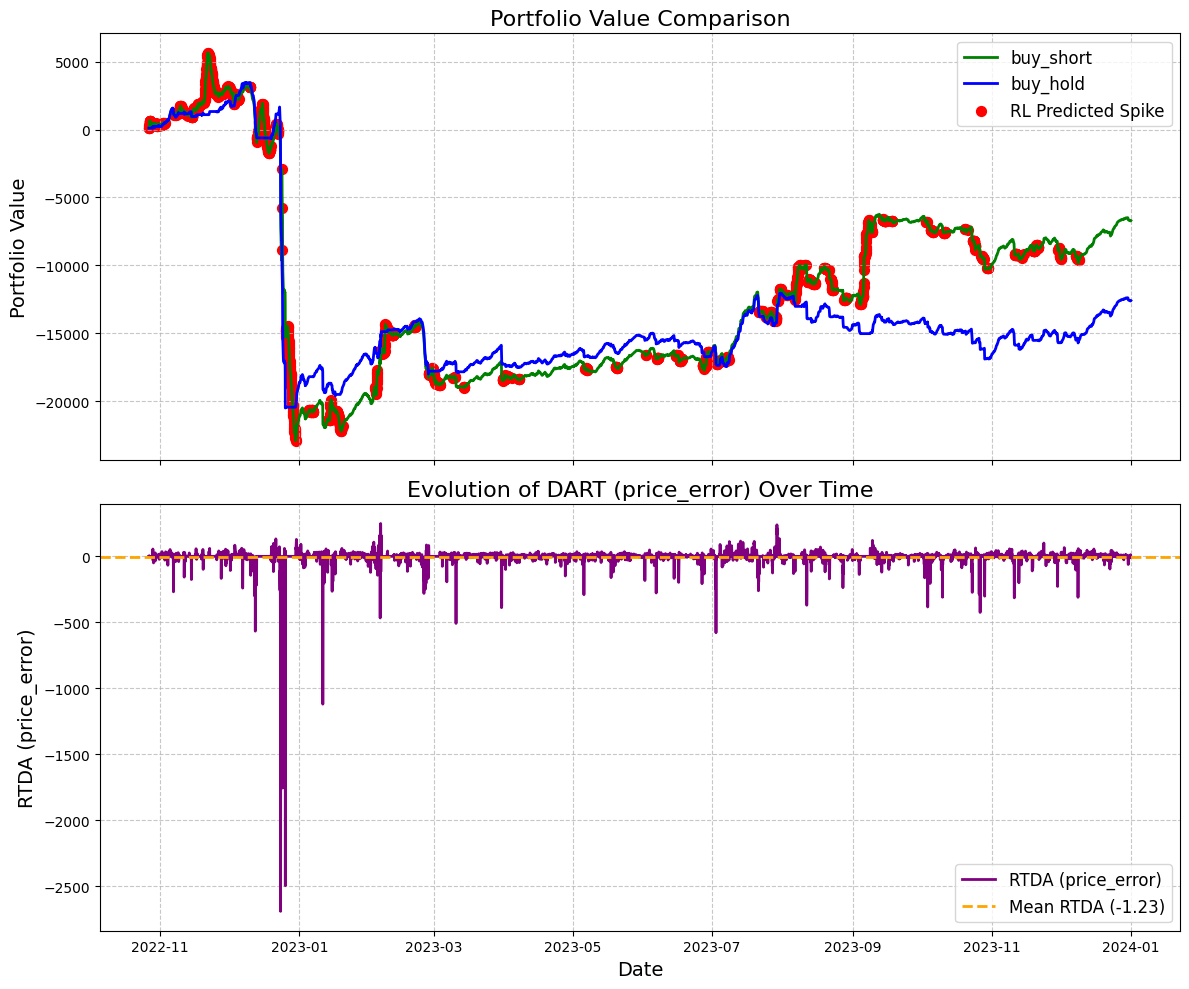

In [20]:
# ---------------------------------
# 8) Create a combined figure with two subplots
# ---------------------------------
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Top subplot: Portfolio Value Comparison
# ax1.plot(df.index, df['portfolio_value_RL'], label='Reinforcement Learning', color='black', linewidth=2)
ax1.plot(df.index, df['long_short'], label='buy_short', color='green', linewidth=2)
ax1.plot(df.index, df['long_hold'], label='buy_hold', color='blue', linewidth=2)
spike_mask = df['predicted_spike_transformer'] == 1
ax1.scatter(df.index[spike_mask], df['long_short'][spike_mask],
            color='red', marker='o', s=50, label='RL Predicted Spike')
ax1.set_title('Portfolio Value Comparison', fontsize=16)
ax1.set_ylabel('Portfolio Value', fontsize=14)
ax1.legend(fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.7)

# Bottom subplot: Evolution of RTDA (price_error) with mean line
ax2.plot(df.index, df['price_error'], color='purple', linewidth=2, label='RTDA (price_error)')
mean_rtda = df['price_error'].mean()
ax2.axhline(mean_rtda, color='orange', linestyle='--', linewidth=2, label=f'Mean RTDA ({mean_rtda:.2f})')
ax2.set_title("Evolution of DART (price_error) Over Time", fontsize=16)
ax2.set_xlabel("Date", fontsize=14)
ax2.set_ylabel("RTDA (price_error)", fontsize=14)
ax2.legend(fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()